In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kieranpoc/steam-reviews")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kieranpoc/steam-reviews/versions/2


In [ ]:
#!unzip '/root/.cache/kagglehub/datasets/kieranpoc/steam-reviews/versions/2'

In [32]:
datafile= '/root/.cache/kagglehub/datasets/kieranpoc/steam-reviews/versions/2/*.csv'
df = dd.read_csv(
    datafile,
    blocksize="64MB",
    on_bad_lines='skip',
    dtype={'steam_china_location': 'object'},
)

df.head()

,recommendationid,appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,1696305457,...,1,99,2,0.889438,0,1,0,0,1,<NA>
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,1696096555,...,1,122,8,0.914834,0,1,0,0,1,<NA>
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,1697630734,...,1,599,20,0.968375,3,1,0,0,1,<NA>
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,1698261011,...,1,59,12,0.826206,0,0,0,0,1,<NA>
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,1697810991,...,1,128,24,0.853612,0,1,0,0,1,<NA>


In [52]:
#Dropping some columns
df = df.drop(['hidden_in_steam_china', 'steam_china_location', 'appid', 'author_playtime_last_two_weeks', 'author_last_played'], axis= 1)
df.head()

KeyError: "['hidden_in_steam_china', 'steam_china_location', 'appid', 'author_playtime_last_two_weeks', 'author_last_played'] not found in axis"

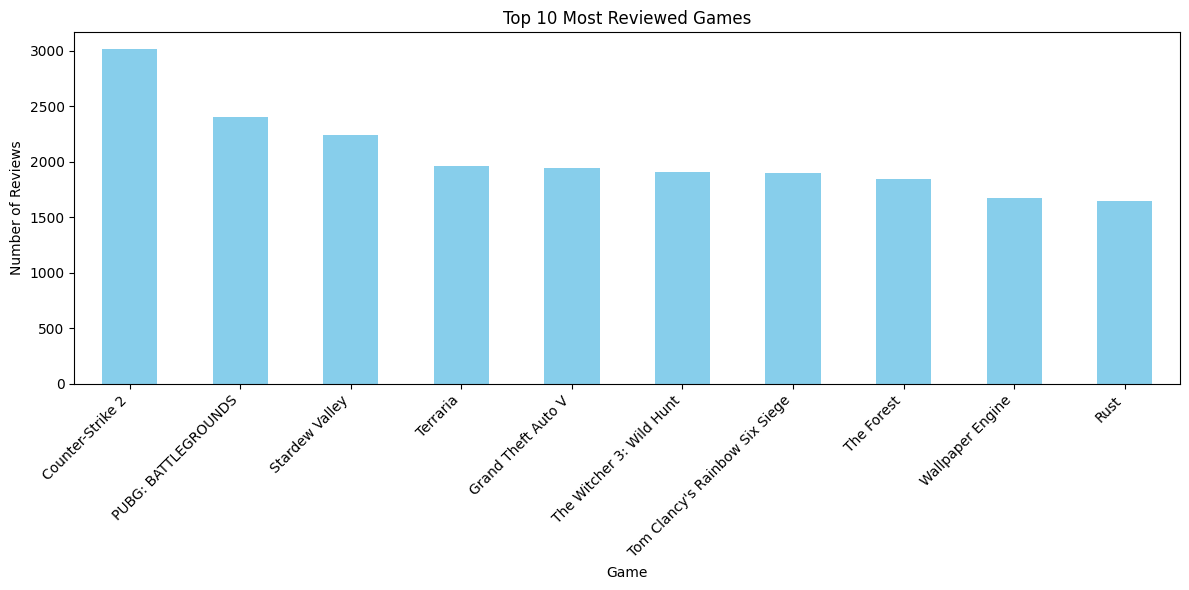

In [40]:
review_counts = df['game'].value_counts().compute()
top_10 = review_counts.nlargest(10)
plt.figure(figsize=(12, 6))
top_10.plot(kind='bar', color='skyblue')
plt.title("Top 10 Most Reviewed Games")
plt.xlabel("Game")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

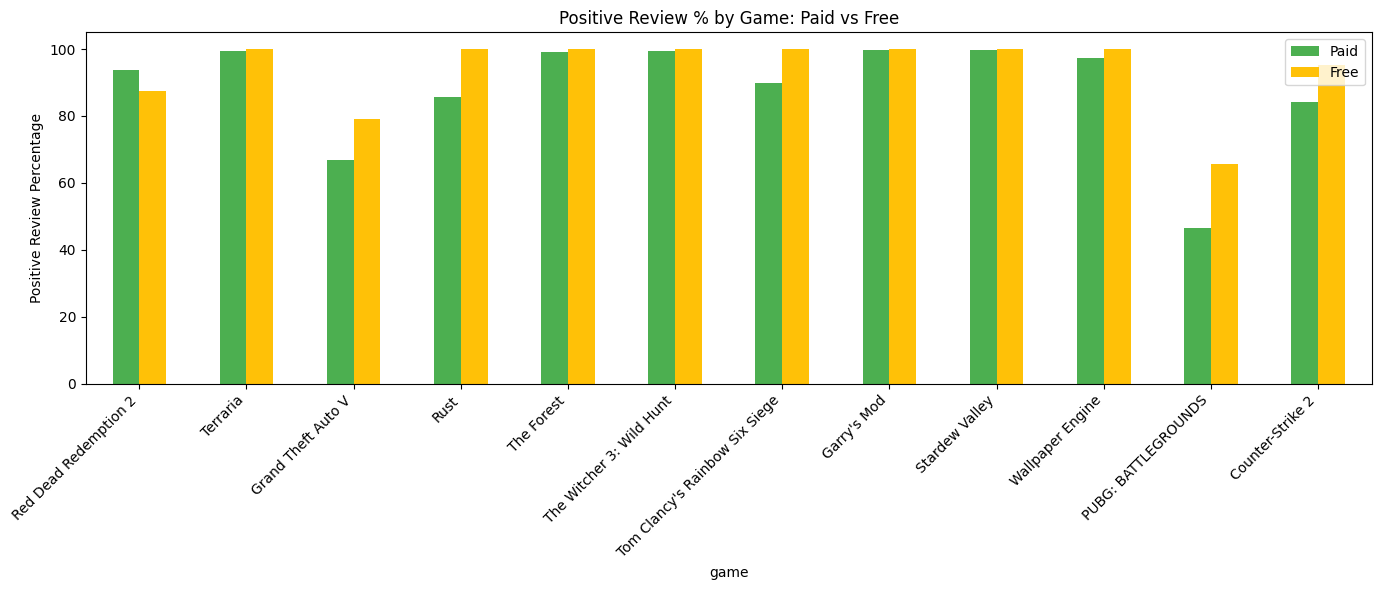

In [ ]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
top_games = df['game'].value_counts().nlargest(12).compute().index.tolist()
filtered_df = df[df['game'].isin(top_games)]
grouped = filtered_df.groupby(['game', 'received_for_free'])['voted_up'].mean().compute()
pivot_df = grouped.unstack('received_for_free')
pivot_df.columns = ['Paid', 'Free']
pivot_df *= 100
pivot_df.plot(kind='bar', figsize=(14, 6), color=['#4CAF50', '#FFC107'])
plt.ylabel('Positive Review Percentage')
plt.title('Positive Review % by Game: Paid vs Free')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


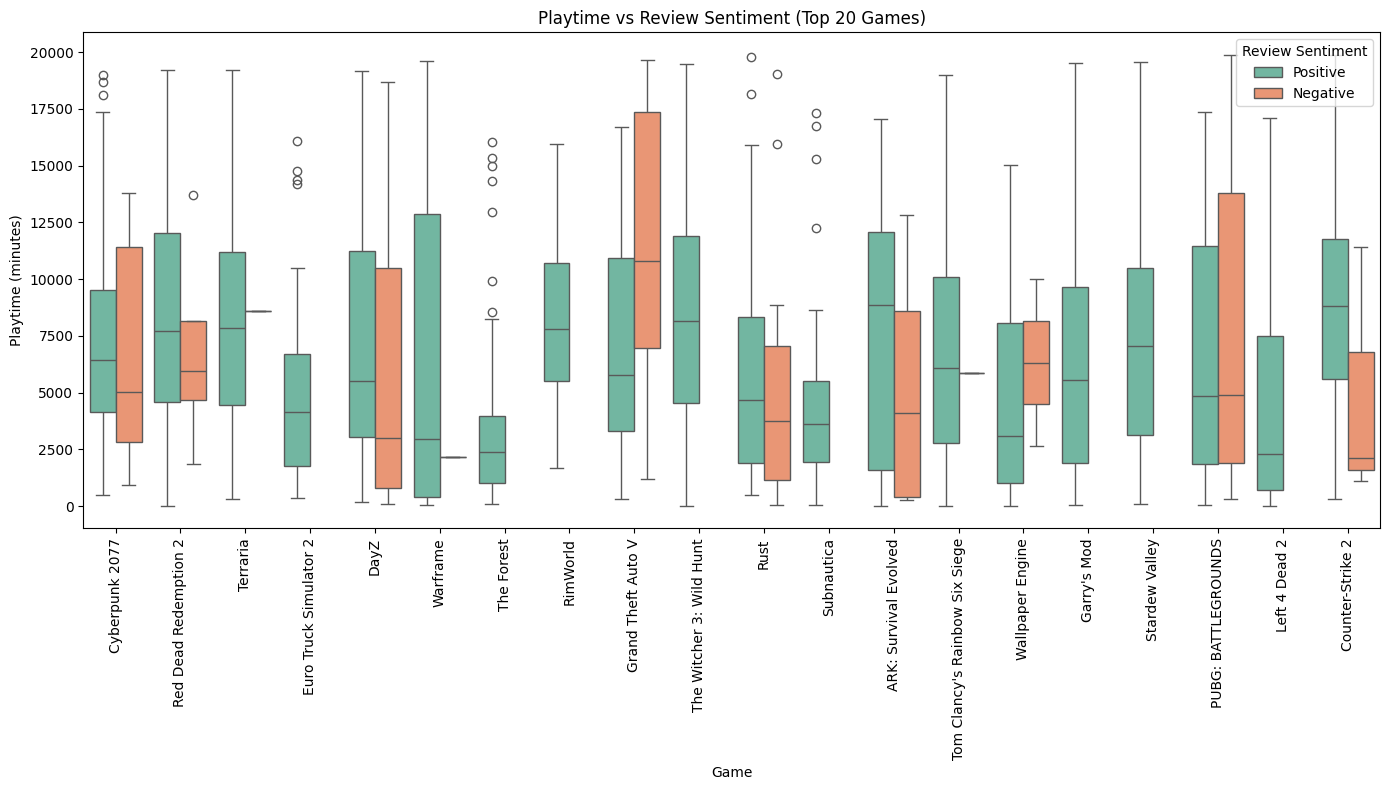

In [51]:

top_games = df['game'].value_counts().nlargest(20).index.compute()

df_top = df[df['game'].isin(top_games)]

df_sample = df_top[['game', 'author_playtime_forever', 'voted_up']].dropna().sample(frac=0.05).compute()

df_sample = df_sample[df_sample['author_playtime_forever'] < 20000]

df_sample['voted_up'] = df_sample['voted_up'].map({1: 'Positive', 0: 'Negative'})

plt.figure(figsize=(14, 8))
sns.boxplot(x='game', y='author_playtime_forever', hue='voted_up', data=df_sample, palette='Set2')
plt.xticks(rotation=90)
plt.title('Playtime vs Review Sentiment (Top 20 Games)')
plt.xlabel('Game')
plt.ylabel('Playtime (minutes)')
plt.legend(title='Review Sentiment')
plt.tight_layout()
plt.show()


In [64]:

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SteamReviews").getOrCreate()
df = spark.read.csv('/root/.cache/kagglehub/datasets/kieranpoc/steam-reviews/versions/2/*.csv', header=True, inferSchema=True)
from pyspark.sql.functions import col

data = df.select(
    col("voted_up").cast("double").alias("label"),
    col("author_num_games_owned").cast("int"),
    col("author_playtime_at_review").cast("int"),
    col("comment_count").cast("int")
).na.drop()
data = data.withColumn("label", when(col("label") > 0, 1.0).otherwise(0.0))
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
print("Training rows:", train_data.count())
print("Test rows:", test_data.count())
train_data.show(5)


tar: spark-3.3.1-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
Training rows: 359774
Test rows: 89869
+-----+----------------------+-------------------------+-------------+
|label|author_num_games_owned|author_playtime_at_review|comment_count|
+-----+----------------------+-------------------------+-------------+
|  0.0|                     0|                        0|            0|
|  0.0|                     0|                        0|            0|
|  0.0|                     0|                        0|            0|
|  0.0|                     0|                        0|            0|
|  0.0|                     0|                        0|            0|
+-----+----------------------+-------------------------+-------------+
only showing top 5 rows



In [65]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when, col

data = data.withColumn("label", when(col("label") > 0, 1.0).otherwise(0.0))
feature_cols = ["author_num_games_owned", "author_playtime_at_review", "comment_count"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(train_data)
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(predictions)

print(f"Test Set AUC: {accuracy:.4f}")

Test Set AUC: 0.6101
